# TODO:
- feature engineering
 - check how to optimize one hot encoding categorical features
 - check correlation of binary(two categories) features with target
 - check if one-hot-encoding for many-values features is bad
 - test for excluding categories which have dominant value
 - find where to apply dimensionality reduction with Lasso, and adjust alpha as hyperparameter
 - encode categorical features, check performance of regression trees
 - check usefulness of each feature by permutation importance(remove each feature and check if model score improved)
- test stacking models using given features along with predictions from stack
- stack models using neural network

# What ideas worked:
- log transform target
- using xgboost with one hot encoding
- lightbgm is better than xgboost
- stacking lightbgm and xgboost with linear regression is better than all of them

# What ideas failed:
- removing outliers made worse performane
- z-transforming OverallQual before (cross-validation) made data leakage and caused overfitting
- dimension reduction after dropping categorical columns using Lasso changed nothing for: Linear regression, XGBoost and RegressionForest
- stacking lightbgm and xgboost with regression random forest overfits and performs bad

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("whitegrid")

import numpy as np

import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [2]:
iowa_file_path = '/kaggle/input/house-prices-advanced-regression-techniques/train.csv'
test_file_path = '/kaggle/input/house-prices-advanced-regression-techniques/test.csv'

home_data = pd.read_csv(iowa_file_path, index_col="Id")

# Data exploration

In [3]:
home_data.shape

(1460, 80)

In [4]:
for feature_name, dtype in zip(home_data.columns, home_data.dtypes):
    print(f"{feature_name:12s}: {dtype}")

MSSubClass  : int64
MSZoning    : object
LotFrontage : float64
LotArea     : int64
Street      : object
Alley       : object
LotShape    : object
LandContour : object
Utilities   : object
LotConfig   : object
LandSlope   : object
Neighborhood: object
Condition1  : object
Condition2  : object
BldgType    : object
HouseStyle  : object
OverallQual : int64
OverallCond : int64
YearBuilt   : int64
YearRemodAdd: int64
RoofStyle   : object
RoofMatl    : object
Exterior1st : object
Exterior2nd : object
MasVnrType  : object
MasVnrArea  : float64
ExterQual   : object
ExterCond   : object
Foundation  : object
BsmtQual    : object
BsmtCond    : object
BsmtExposure: object
BsmtFinType1: object
BsmtFinSF1  : int64
BsmtFinType2: object
BsmtFinSF2  : int64
BsmtUnfSF   : int64
TotalBsmtSF : int64
Heating     : object
HeatingQC   : object
CentralAir  : object
Electrical  : object
1stFlrSF    : int64
2ndFlrSF    : int64
LowQualFinSF: int64
GrLivArea   : int64
BsmtFullBath: int64
BsmtHalfBath: int64
FullBa

## SalePrice(target)

SalePrice distribution is log-normal distributed, so it is reasonable to apply log to it before making model

Before applying log
SalePrice skew: 1.883


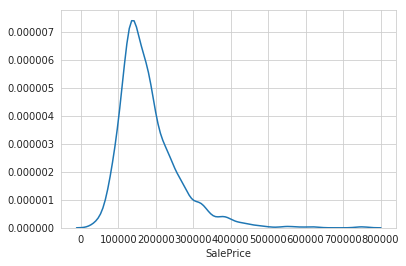

After applying log
SalePrice skew: 0.121


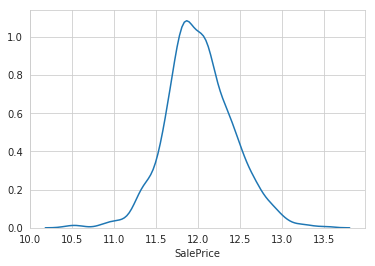

In [5]:
print("Before applying log")
print(f"SalePrice skew: {home_data['SalePrice'].skew():.3f}")
sns.distplot(home_data['SalePrice'], hist=False)
plt.show()
print("After applying log")
logy = np.log(home_data['SalePrice'])
print(f"SalePrice skew: {logy.skew():.3f}")
sns.distplot(logy, hist=False)
plt.show()

Correlation with numerical features

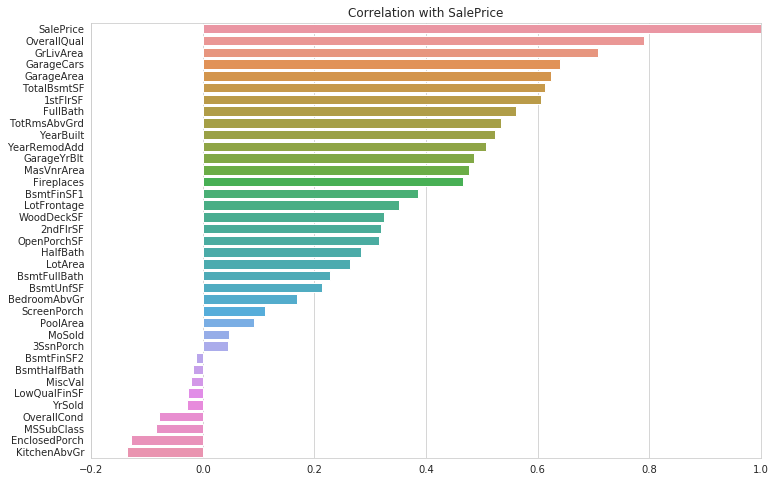

In [6]:
data = home_data.corr()["SalePrice"].sort_values()[::-1]
plt.figure(figsize=(12, 8))
sns.barplot(x=data.values, y=data.index)
plt.title("Correlation with SalePrice")
plt.xlim(-0.2, 1)
plt.show()

## OverallQual

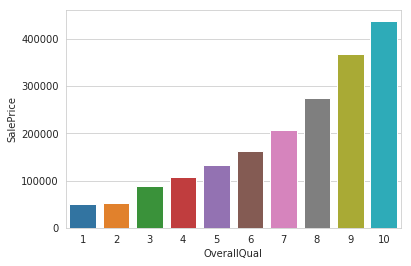

In [7]:
data = home_data.pivot_table(index="OverallQual", values="SalePrice", aggfunc="mean")
sns.barplot(x=data.index, y=data["SalePrice"])
plt.show()

## GrLiveArea

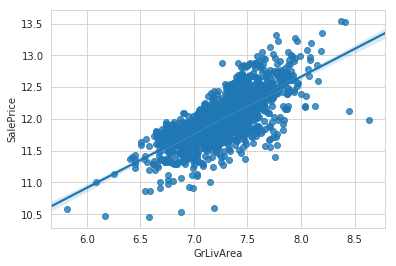

In [8]:
data = home_data[["GrLivArea", "SalePrice"]]
sns.regplot(x=np.log(data["GrLivArea"]), y=np.log(data["SalePrice"]))
plt.show()

## GarageArea

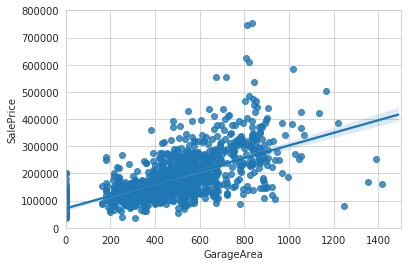

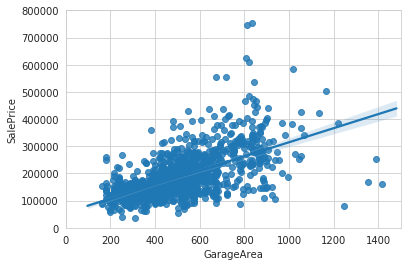

In [9]:
sns.regplot(x="GarageArea", y="SalePrice", data=home_data[["GarageArea", "SalePrice"]])
plt.xlim(0, 1500)
plt.ylim(0, 800000)
plt.show()
data = home_data[["GarageArea", "SalePrice"]]
data = data[data["GarageArea"] > 0]
sns.regplot(x="GarageArea", y="SalePrice", data=data)
plt.xlim(0, 1500)
plt.ylim(0, 800000)
plt.show()

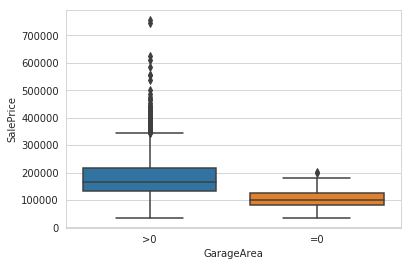

In [10]:
data_tmp = pd.DataFrame(columns=["GarageArea", "SalePrice"])
for garage_area, sale_price in home_data[["GarageArea", "SalePrice"]].values:
    data_tmp = data_tmp.append(pd.DataFrame([[">0" if garage_area > 0 else "=0", sale_price]], columns=data_tmp.columns))
data_tmp["SalePrice"] = data_tmp["SalePrice"].apply(float)
sns.boxplot(x="GarageArea", y="SalePrice", data=data_tmp)
plt.show()

## GarageCars

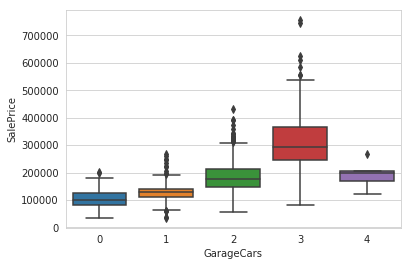

GarageCars: Entries count
2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64


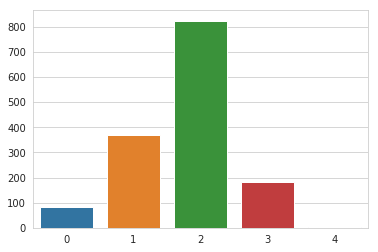

In [11]:
data = home_data[["GarageCars", "SalePrice"]]
sns.boxplot(data["GarageCars"], y=data["SalePrice"])
plt.show()
data = home_data["GarageCars"].value_counts()
print("GarageCars: Entries count")
print(data)
sns.barplot(x=data.index, y=data.values)
plt.show()

## MSZoning

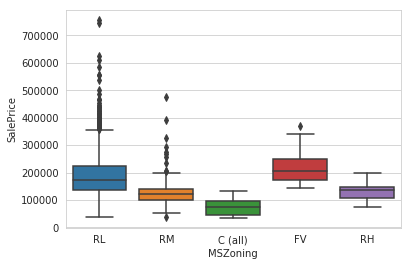

In [12]:
data = home_data[["MSZoning", "SalePrice"]]
sns.boxplot(x="MSZoning", y="SalePrice", data=data)
plt.show()

## Alley

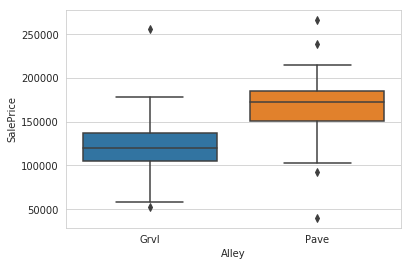

In [13]:
data = home_data[["Alley", "SalePrice"]]
sns.boxplot(x="Alley", y="SalePrice", data=data)
plt.show()

## LotShape

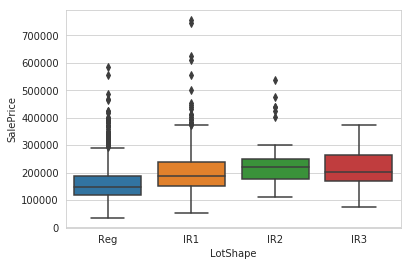

In [14]:
data = home_data[["LotShape", "SalePrice"]]
sns.boxplot(x="LotShape", y="SalePrice", data=data)
plt.show()

## LandContour

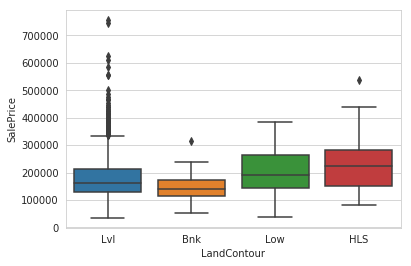

In [15]:
data = home_data[["LandContour", "SalePrice"]]
sns.boxplot(x="LandContour", y="SalePrice", data=data)
plt.show()

## Utilities

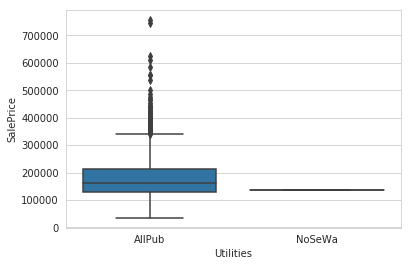

In [16]:
data = home_data[["Utilities", "SalePrice"]]
sns.boxplot(x="Utilities", y="SalePrice", data=data)
plt.show()

## LotConfig

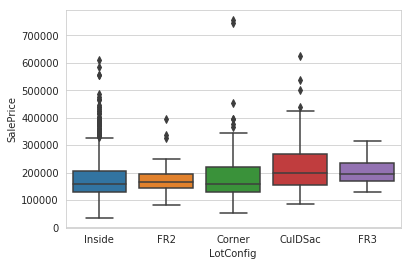

In [17]:
data = home_data[["LotConfig", "SalePrice"]]
sns.boxplot(x="LotConfig", y="SalePrice", data=data)
plt.show()

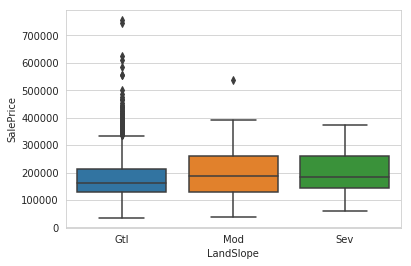

In [18]:
data = home_data[["LandSlope", "SalePrice"]]
sns.boxplot(x="LandSlope", y="SalePrice", data=data)
plt.show()

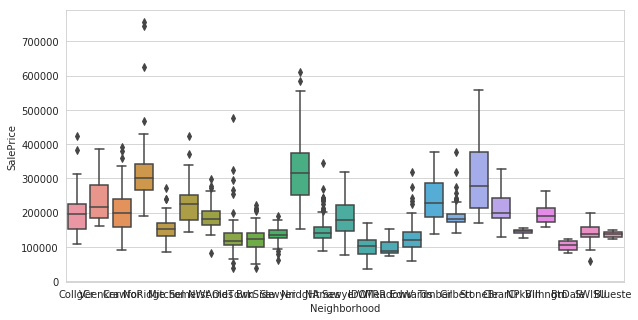

In [19]:
## Neighborhood
data = home_data[["Neighborhood", "SalePrice"]]
plt.figure(figsize=(10, 5))
sns.boxplot(x="Neighborhood", y="SalePrice", data=data)
plt.show()

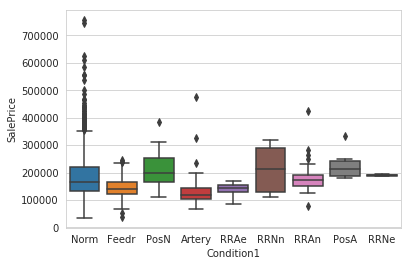

In [20]:
## Condition1
data = home_data[["Condition1", "SalePrice"]]
sns.boxplot(x="Condition1", y="SalePrice", data=data)
plt.show()

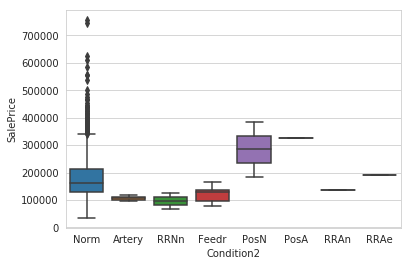

In [21]:
## Condition2
data = home_data[["Condition2", "SalePrice"]]
sns.boxplot(x="Condition2", y="SalePrice", data=data)
plt.show()

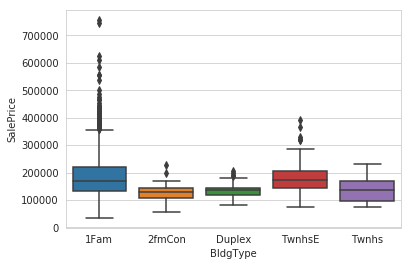

In [22]:
## BldgType
data = home_data[["BldgType", "SalePrice"]]
sns.boxplot(x="BldgType", y="SalePrice", data=data)
plt.show()

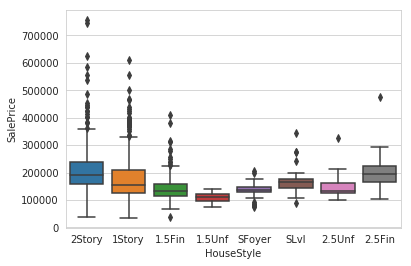

In [23]:
## HouseStyle
data = home_data[["HouseStyle", "SalePrice"]]
sns.boxplot(x="HouseStyle", y="SalePrice", data=data)
plt.show()

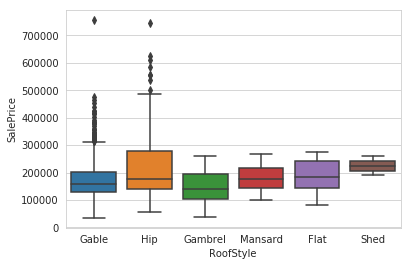

In [24]:
## RoofStyle
data = home_data[["RoofStyle", "SalePrice"]]
sns.boxplot(x="RoofStyle", y="SalePrice", data=data)
plt.show()

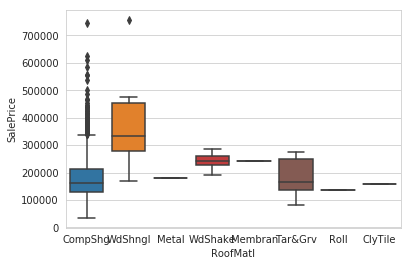

In [25]:
## RoofMatl
data = home_data[["RoofMatl", "SalePrice"]]
sns.boxplot(x="RoofMatl", y="SalePrice", data=data)
plt.show()

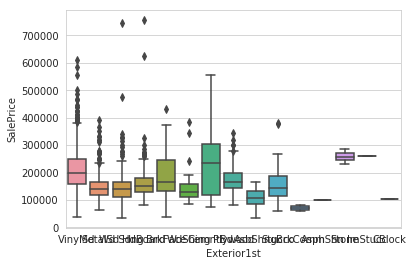

In [26]:
## Exterior1st
data = home_data[["Exterior1st", "SalePrice"]]
sns.boxplot(x="Exterior1st", y="SalePrice", data=data)
plt.show()

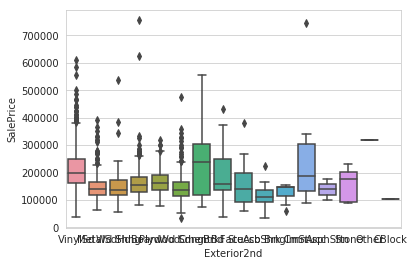

In [27]:
## Exterior2nd
data = home_data[["Exterior2nd", "SalePrice"]]
sns.boxplot(x="Exterior2nd", y="SalePrice", data=data)
plt.show()

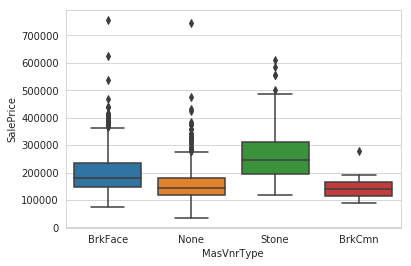

In [28]:
## MasVnrType
data = home_data[["MasVnrType", "SalePrice"]]
sns.boxplot(x="MasVnrType", y="SalePrice", data=data)
plt.show()

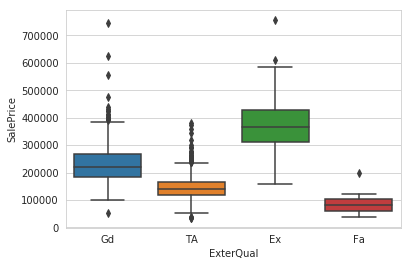

In [29]:
## ExterQual
data = home_data[["ExterQual", "SalePrice"]]
sns.boxplot(x="ExterQual", y="SalePrice", data=data)
plt.show()

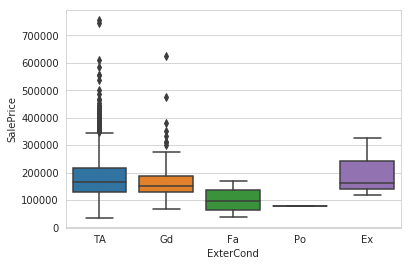

In [30]:
## ExterCond
data = home_data[["ExterCond", "SalePrice"]]
sns.boxplot(x="ExterCond", y="SalePrice", data=data)
plt.show()

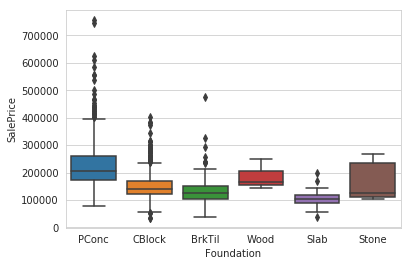

In [31]:
## Foundation
data = home_data[["Foundation", "SalePrice"]]
sns.boxplot(x="Foundation", y="SalePrice", data=data)
plt.show()

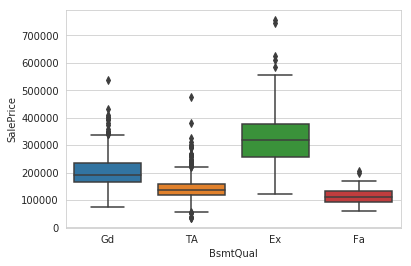

In [32]:
## BsmtQual
data = home_data[["BsmtQual", "SalePrice"]]
sns.boxplot(x="BsmtQual", y="SalePrice", data=data)
plt.show()

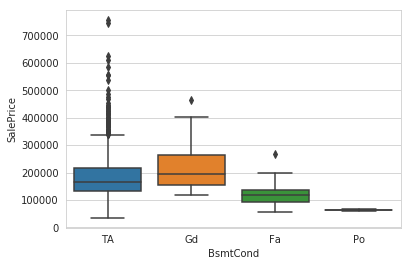

In [33]:
## BsmtCond
data = home_data[["BsmtCond", "SalePrice"]]
sns.boxplot(x="BsmtCond", y="SalePrice", data=data)
plt.show()

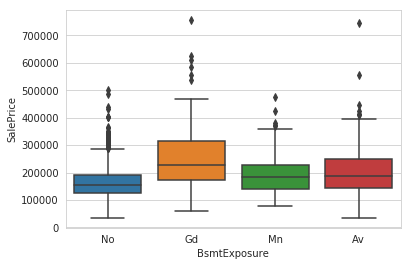

In [34]:
## BsmtExposure
data = home_data[["BsmtExposure", "SalePrice"]]
sns.boxplot(x="BsmtExposure", y="SalePrice", data=data)
plt.show()

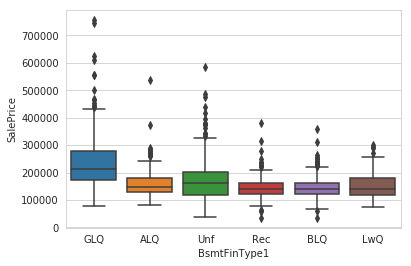

In [35]:
## BsmtFinType1
data = home_data[["BsmtFinType1", "SalePrice"]]
sns.boxplot(x="BsmtFinType1", y="SalePrice", data=data)
plt.show()

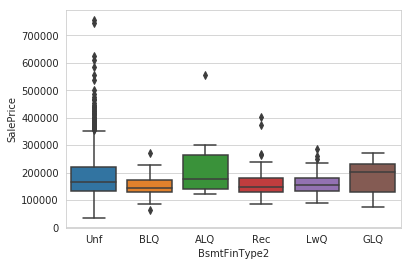

In [36]:
## BsmtFinType2
data = home_data[["BsmtFinType2", "SalePrice"]]
sns.boxplot(x="BsmtFinType2", y="SalePrice", data=data)
plt.show()

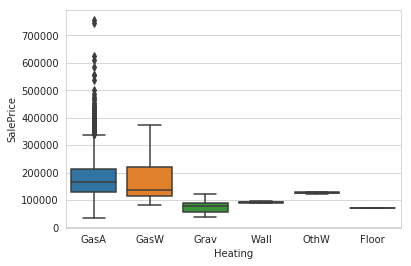

In [37]:
## Heating
data = home_data[["Heating", "SalePrice"]]
sns.boxplot(x="Heating", y="SalePrice", data=data)
plt.show()

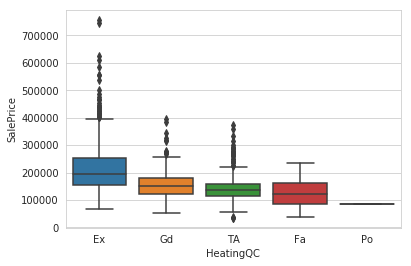

In [38]:
## HeatingQC
data = home_data[["HeatingQC", "SalePrice"]]
sns.boxplot(x="HeatingQC", y="SalePrice", data=data)
plt.show()

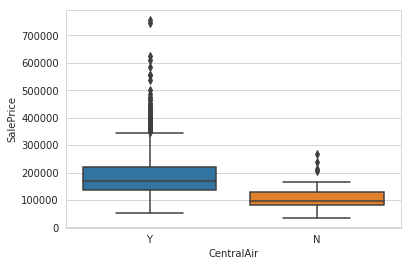

In [39]:
## CentralAir
data = home_data[["CentralAir", "SalePrice"]]
sns.boxplot(x="CentralAir", y="SalePrice", data=data)
plt.show()

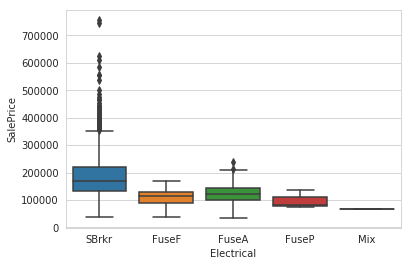

In [40]:
## Electrical
data = home_data[["Electrical", "SalePrice"]]
sns.boxplot(x="Electrical", y="SalePrice", data=data)
plt.show()

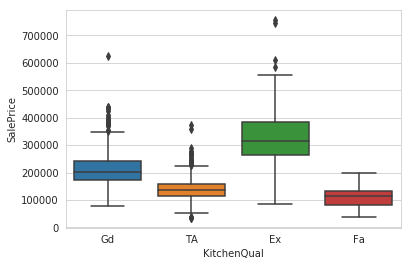

In [41]:
## KitchenQual
data = home_data[["KitchenQual", "SalePrice"]]
sns.boxplot(x="KitchenQual", y="SalePrice", data=data)
plt.show()

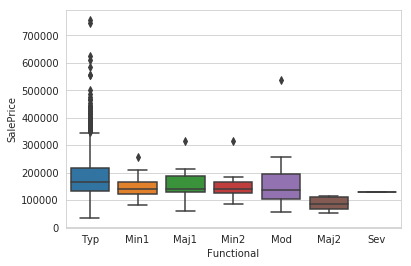

In [42]:
## Functional
data = home_data[["Functional", "SalePrice"]]
sns.boxplot(x="Functional", y="SalePrice", data=data)
plt.show()

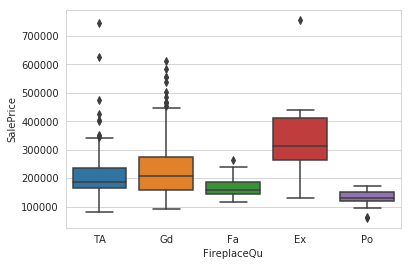

In [43]:
## FireplaceQu
data = home_data[["FireplaceQu", "SalePrice"]]
sns.boxplot(x="FireplaceQu", y="SalePrice", data=data)
plt.show()

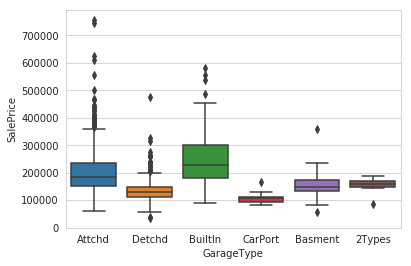

In [44]:
## GarageType
data = home_data[["GarageType", "SalePrice"]]
sns.boxplot(x="GarageType", y="SalePrice", data=data)
plt.show()

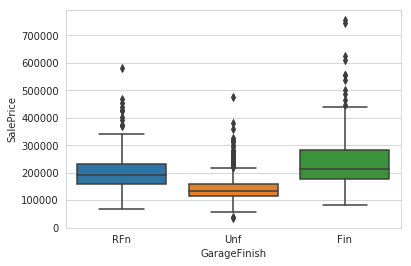

In [45]:
## GarageFinish
data = home_data[["GarageFinish", "SalePrice"]]
sns.boxplot(x="GarageFinish", y="SalePrice", data=data)
plt.show()

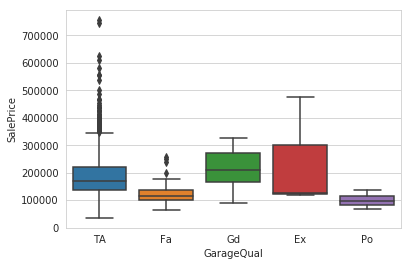

In [46]:
## GarageQual
data = home_data[["GarageQual", "SalePrice"]]
sns.boxplot(x="GarageQual", y="SalePrice", data=data)
plt.show()

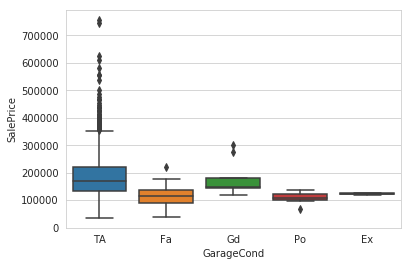

In [47]:
## GarageCond
data = home_data[["GarageCond", "SalePrice"]]
sns.boxplot(x="GarageCond", y="SalePrice", data=data)
plt.show()

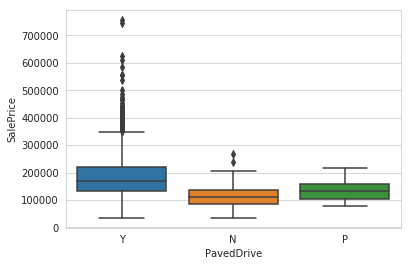

In [48]:
## PavedDrive
data = home_data[["PavedDrive", "SalePrice"]]
sns.boxplot(x="PavedDrive", y="SalePrice", data=data)
plt.show()

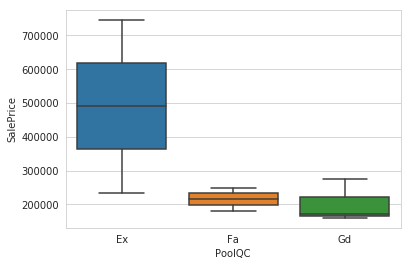

In [49]:
## PoolQC
data = home_data[["PoolQC", "SalePrice"]]
sns.boxplot(x="PoolQC", y="SalePrice", data=data)
plt.show()

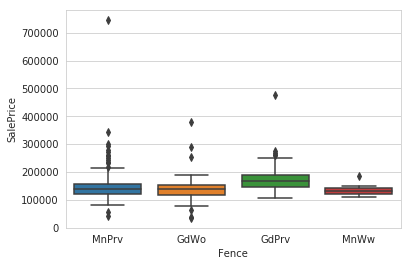

In [50]:
## Fence
data = home_data[["Fence", "SalePrice"]]
sns.boxplot(x="Fence", y="SalePrice", data=data)
plt.show()

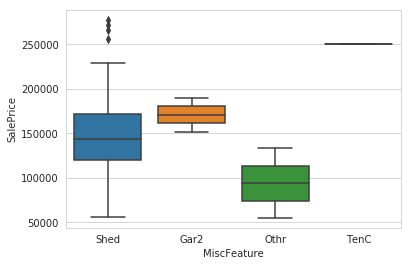

In [51]:
## MiscFeature
data = home_data[["MiscFeature", "SalePrice"]]
sns.boxplot(x="MiscFeature", y="SalePrice", data=data)
plt.show()

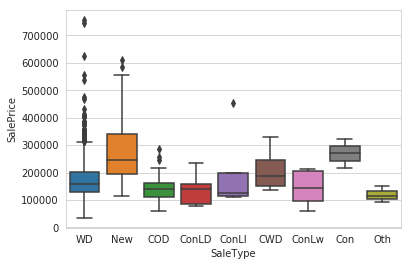

In [52]:
## SaleType
data = home_data[["SaleType", "SalePrice"]]
sns.boxplot(x="SaleType", y="SalePrice", data=data)
plt.show()

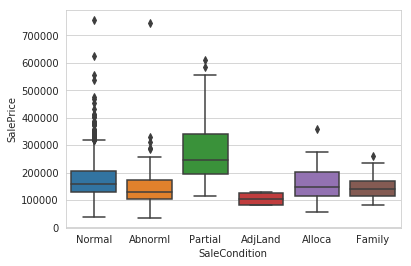

In [53]:
## SaleCondition
data = home_data[["SaleCondition", "SalePrice"]]
sns.boxplot(x="SaleCondition", y="SalePrice", data=data)
plt.show()

## Null values research

In [54]:
nulls = pd.DataFrame(home_data.isnull().sum().sort_values(ascending=False))
nulls.columns = ["Null count"]
nulls["Unique"] = home_data[nulls.index].nunique()
nulls["dtype"] = home_data[nulls.index].dtypes
nulls[nulls["Null count"] > 0]

,Null count,Unique,dtype
PoolQC,1453,3,object
MiscFeature,1406,4,object
Alley,1369,2,object
Fence,1179,4,object
FireplaceQu,690,5,object
LotFrontage,259,110,float64
GarageType,81,6,object
GarageCond,81,5,object
GarageFinish,81,3,object
GarageQual,81,5,object


# Modelling

In [55]:
home_data["GarageArea=0"] = (home_data["GarageArea"] == 0).apply(float)
home_data["GarageCars=4"] = (home_data["GarageCars"] == 4).apply(float)
home_data["MSSubClass"] = home_data["MSSubClass"].apply(str)

home_data["NotHasBasement"] = home_data["BsmtExposure"].isnull()
home_data["BsmtExposure"] = home_data["BsmtExposure"].fillna("NoBasement")
home_data["BsmtQual"] = home_data["BsmtQual"].fillna("NoBasement")
home_data["BsmtCond"] = home_data["BsmtCond"].fillna("NoBasement")
home_data["BsmtFinType1"] = home_data["BsmtFinType1"].fillna("NoBasement")
home_data["BsmtFinType2"] = home_data["BsmtFinType2"].fillna("NoBasement")

home_data["NotHasFireplace"] = home_data["FireplaceQu"].isnull()
home_data["FireplaceQu"] = home_data["FireplaceQu"].fillna("NoFireplace")

home_data["NotHasGarage"] = home_data["GarageFinish"].isnull()
home_data["GarageFinish"] = home_data["GarageFinish"].fillna("NoGarage")
home_data["GarageQual"] = home_data["GarageQual"].fillna("NoGarage")
home_data["GarageType"] = home_data["GarageType"].fillna("NoGarage")
home_data["GarageCond"] = home_data["GarageCond"].fillna("NoGarage")

home_data["NotHasPool"] = home_data["PoolQC"].isnull()
home_data["PoolQC"] = home_data["PoolQC"].fillna("NoPool")

home_data["NotHasFence"] = home_data["Fence"].isnull()
home_data["Fence"] = home_data["Fence"].fillna("NoFence")

home_data["NotHasKitchen"] = home_data["KitchenQual"].isnull()
home_data["KitchenQual"] = home_data["KitchenQual"].fillna("NoKitchen")

#home_data["MiscFeature"] = home_data["MiscFeature"].fillna("NA")
#home_data["Alley"] = home_data["Alley"].fillna("NA")
#home_data["LotFrontage"] = home_data["LotFrontage"].fillna(home_data["LotFrontage"].min())
#home_data["GarageYrBlt"] = home_data["GarageYrBlt"].fillna(home_data["GarageYrBlt"].min())
#home_data["MasVnrType"] = home_data["MasVnrType"].fillna("NA")
#home_data["MasVnrArea"] = home_data["MasVnrArea"].fillna(home_data["MasVnrArea"].min())
#home_data["Electrical"] = home_data["Electrical"].fillna("NA")

In [56]:
def show_nulls(df):
    nulls = pd.DataFrame(df.isnull().sum().sort_values(ascending=False))
    nulls.columns = ["Null count"]
    nulls["Unique"] = df[nulls.index].nunique()
    nulls["dtype"] = df[nulls.index].dtypes
    return nulls[nulls["Null count"] > 0]
show_nulls(home_data)

,Null count,Unique,dtype
MiscFeature,1406,4,object
Alley,1369,2,object
LotFrontage,259,110,float64
GarageYrBlt,81,97,float64
MasVnrType,8,4,object
MasVnrArea,8,327,float64
Electrical,1,5,object


In [57]:
y = home_data["SalePrice"].values
X = home_data.drop("SalePrice", axis=1)

In [58]:
models_performance = pd.DataFrame(columns=["Model", "CV", "Full"])

def calc_score(y_true, y_pred):
    logy_true = np.log1p(y_true)
    logy_pred = np.log1p(y_pred)
    return np.sqrt(np.sum((logy_true - logy_pred) ** 2) / y_true.shape[0]) 

def test_pipeline(pipeline, name="Unnamed"):
    # Uncomment when commit
    return
    scores = cross_val_score(pipeline, X, y, cv=10, scoring=make_scorer(calc_score))
    print(f"Mean CV score: {scores.mean():,.5f}")

    pipeline.fit(X, y)
    full_score = calc_score(y, pipeline.predict(X))
    print(f"Full score: {full_score:,.5f}")
    
    global models_performance
    models_performance = models_performance.append(pd.DataFrame([[name, scores.mean(), full_score]], columns=models_performance.columns))

Function to transform model into model predicting log(target)

In [59]:
def log_model(model):
    return TransformedTargetRegressor(model, func=np.log1p, inverse_func=np.expm1)

In [60]:
numerical_cols = X.select_dtypes(exclude=['object']).columns
ordinal_cols = ["LotShape", "LandContour", "LandSlope", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", "CentralAir", "KitchenQual", "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond", "PavedDrive", "PoolQC", "Fence"]
categorical_cols = [col for col in X.select_dtypes(include=["object"]).columns if col not in ordinal_cols]

# Impute numerical features with mean
# Impute categoricals and onehot encode them
preprocessor = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='mean'), numerical_cols),
    ('cat', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_cols)
##     ('num', SimpleImputer(strategy='mean', verbose=2), numerical_cols),
##     ('imp', SimpleImputer(strategy='constant', verbose=2), ordinal_cols),
##     ('const', SimpleImputer(strategy='constant', verbose=2), categorical_cols),
##     ('onehot encode', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
#     ('encode Street', OrdinalEncoder(categories=[["Grvl", "Pave"]]), ["Street"]),
#     ('encode LotShape', OrdinalEncoder(categories=[["Reg", "IR1", "IR2", "IR3"]]), ["LotShape"]),
#     ('encode LandContour', OrdinalEncoder(categories=[["Lvl", "Bnk", "HLS", "Low"]]), ["LandContour"]),
#     ('encode LandSlope', OrdinalEncoder(categories=[["Gtl", "Mod", "Sev"]]), ["LandSlope"]),
#     ('encode ExterQual', OrdinalEncoder(categories=[["Ex", "Gd", "TA", "Fa", "Po"]]), ["ExterQual"]),
#     ('encode ExterCond', OrdinalEncoder(categories=[["Ex", "Gd", "TA", "Fa", "Po"]]), ["ExterCond"]),
#     ('encode BsmtQual', OrdinalEncoder(categories=[["Ex", "Gd", "TA", "Fa", "Po", "NoBasement"]]), ["BsmtQual"]),
#     ('encode BsmtCond', OrdinalEncoder(categories=[["Ex", "Gd", "TA", "Fa", "Po", "NoBasement"]]), ["BsmtCond"]),
#     ('encode BsmtExposure', OrdinalEncoder(categories=[["Gd", "Av", "Mn", "No", "NoBasement"]]), ["BsmtExposure"]),
#     ('encode BsmtFinType1', OrdinalEncoder(categories=[["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "NoBasement"]]), ["BsmtFinType1"]),
#     ('encode BsmtFinType2', OrdinalEncoder(categories=[["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "NoBasement"]]), ["BsmtFinType2"]),
#     ('encode HeatingQC', OrdinalEncoder(categories=[["Ex", "Gd", "TA", "Fa", "Po"]]), ["HeatingQC"]),
#     ('encode CentralAir', OrdinalEncoder(categories=[["Y", "N"]]), ["CentralAir"]),
#     ('encode KitchenQual', OrdinalEncoder(categories=[["Ex", "Gd", "TA", "Fa", "Po"]]), ["KitchenQual"]),
#     ('encode FireplaceQu', OrdinalEncoder(categories=[["Ex", "Gd", "TA", "Fa", "Po", "NoFireplace"]]), ["FireplaceQu"]),
#     ('encode GarageFinish', OrdinalEncoder(categories=[["Fin", "RFn", "Unf", "NoGarage"]]), ["GarageFinish"]),
#     ('encode GarageQual', OrdinalEncoder(categories=[["Ex", "Gd", "TA", "Fa", "Po", "NoGarage"]]), ["GarageQual"]),
#     ('encode GarageCond', OrdinalEncoder(categories=[["Ex", "Gd", "TA", "Fa", "Po", "NoGarage"]]), ["GarageCond"]),
#     ('encode PavedDrive', OrdinalEncoder(categories=[["Y", "P", "N"]]), ["PavedDrive"]),
#     ('encode PoolQC', OrdinalEncoder(categories=[["Ex", "Gd", "TA", "Fa", "Po", "NoPool"]]), ["PoolQC"]),
#     ('encode Fence', OrdinalEncoder(categories=[["GdPrv", "MnPrv", "GdWo", "MnWw", "NoFence"]]), ["Fence"])
])

## Linear regression

In [61]:
lin2_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', log_model(LinearRegression()))
])

test_pipeline(lin2_pipeline, "Linear regression[1]")

## XGBoost

In [62]:
xg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', log_model(XGBRegressor(n_estimators=500, objective='reg:squarederror')))
])

test_pipeline(xg_pipeline, "XGBoost[1]")

In [63]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', log_model(GradientBoostingRegressor()))
])

test_pipeline(gbr_pipeline, "GradientBoostingRegressor[1]")

## RandomForest

In [64]:
random_fores_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', log_model(RandomForestRegressor(n_estimators=100, random_state=1)))
])

test_pipeline(random_fores_pipeline, "Random forest[1]")

## LightGBM

In [65]:
from lightgbm import LGBMRegressor

lightgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', log_model(LGBMRegressor()))
])

test_pipeline(lightgbm_pipeline, "LightGBM[1]")

## Stack XGBoost and LightGBM using linear regression

In [66]:
from sklearn.base import BaseEstimator

class Stacked(BaseEstimator):
    def __init__(self, models, stacker):
        self.models = models
        self.stacker = stacker
    def _meta_predict(self, X):
        metaX = []
        for model in self.models:
            fX = model.predict(X)
            metaX.append(fX)
        return np.vstack(metaX).T
    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
        finX = self._meta_predict(X)
        self.stacker.fit(finX, y)
    def predict(self, X):
        finX = self._meta_predict(X)
        return np.abs(self.stacker.predict(finX))

stacked_model = Stacked([xg_pipeline, lightgbm_pipeline], LinearRegression())
test_pipeline(stacked_model, "LinearRegression(XGBoost, LightGBM)")

In [67]:
from sklearn.neural_network import MLPRegressor

class Stacked(BaseEstimator):
    def __init__(self, models, stacker):
        self.models = models
        self.stacker = stacker
    def _meta_predict(self, X):
        metaX = []
        for model in self.models:
            fX = model.predict(X)
            metaX.append(fX)
        return np.vstack(metaX).T
    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
        finX = self._meta_predict(X)
        self.stacker.fit(finX, y)
    def predict(self, X):
        finX = self._meta_predict(X)
        return np.abs(self.stacker.predict(finX))

stacked_model2020 = Stacked([xg_pipeline, lightgbm_pipeline], MLPRegressor(learning_rate_init=0.01))
test_pipeline(stacked_model2020, "NN(XGBoost, LightGBM)")

In [68]:
class Stacked2(BaseEstimator):
    def __init__(self, models, stacker):
        self.models = models
        self.stacker = stacker
    def _meta_predict(self, X):
        metaX = [preprocessor.transform(X)]
        for model in self.models:
            fX = model.predict(X)
            metaX.append(fX.reshape(fX.shape[0], 1))
        return np.concatenate(metaX, axis=1)
    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
        finX = self._meta_predict(X)
        self.stacker.fit(finX, y)
    def predict(self, X):
        finX = self._meta_predict(X)
        return np.abs(self.stacker.predict(finX))

stacked_model3 = Stacked2([xg_pipeline, lightgbm_pipeline], LinearRegression())
#test_pipeline(stacked_model3, "Stacked(XGBoost, LightGBM)")

In [69]:
stacked_model4 = Stacked([xg_pipeline, gbr_pipeline], LinearRegression())
test_pipeline(stacked_model4, "Stacked(XGBoost, GradientBoostingRegressor)")

In [70]:
models_performance.sort_values("CV")

,Model,CV,Full


In [71]:
test_X = pd.read_csv(test_file_path, index_col='Id')
test_X["GarageArea=0"] = (test_X["GarageArea"] == 0).apply(float)
test_X["GarageCars=4"] = (test_X["GarageCars"] == 4).apply(float)
test_X["MSSubClass"] = test_X["MSSubClass"].apply(str)

test_X["NotHasBasement"] = test_X["BsmtExposure"].isnull()
test_X["BsmtExposure"] = test_X["BsmtExposure"].fillna("NoBasement")
test_X["BsmtQual"] = test_X["BsmtQual"].fillna("NoBasement")
test_X["BsmtCond"] = test_X["BsmtCond"].fillna("NoBasement")
test_X["BsmtFinType1"] = test_X["BsmtFinType1"].fillna("NoBasement")
test_X["BsmtFinType2"] = test_X["BsmtFinType2"].fillna("NoBasement")

test_X["NotHasFireplace"] = test_X["FireplaceQu"].isnull()
test_X["FireplaceQu"] = test_X["FireplaceQu"].fillna("NoFireplace")

test_X["NotHasGarage"] = test_X["GarageFinish"].isnull()
test_X["GarageFinish"] = test_X["GarageFinish"].fillna("NoGarage")
test_X["GarageQual"] = test_X["GarageQual"].fillna("NoGarage")
test_X["GarageType"] = test_X["GarageType"].fillna("NoGarage")
test_X["GarageCond"] = test_X["GarageCond"].fillna("NoGarage")

test_X["NotHasPool"] = test_X["PoolQC"].isnull()
test_X["PoolQC"] = test_X["PoolQC"].fillna("NoPool")

test_X["NotHasFence"] = test_X["Fence"].isnull()
test_X["Fence"] = test_X["Fence"].fillna("NoFence")

test_X["NotHasKitchen"] = test_X["KitchenQual"].isnull()
test_X["KitchenQual"] = test_X["KitchenQual"].fillna("NoKitchen")

best_pipeline = stacked_model2020
best_pipeline.fit(X, y)
pred_y = best_pipeline.predict(test_X)

output = pd.DataFrame({
    'Id': test_X.index,
    'SalePrice': pred_y
})
output.to_csv('submission.csv', index=False)
!head -n5 submission.csv

Id,SalePrice
1461,125121.01482899096
1462,154857.90797718358
1463,183006.74198845096
1464,189671.93613123053


In [72]:
show_nulls(test_X)

,Null count,Unique,dtype
MiscFeature,1408,3,object
Alley,1352,2,object
LotFrontage,227,115,float64
GarageYrBlt,78,97,float64
MasVnrType,16,4,object
MasVnrArea,15,303,float64
MSZoning,4,5,object
BsmtHalfBath,2,3,float64
Utilities,2,1,object
Functional,2,7,object


In [73]:
tft =  test_X
for vals in [tft[col].unique() for col in tft]:
    if None in vals:
        print(vals)

In [74]:
prp = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='mean'), numerical_cols),
    ('const', SimpleImputer(strategy='constant'), categorical_cols)#,
    #('onehot encode', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])
tft =  pd.DataFrame(prp.fit_transform(test_X))
for vals in [tft[col].unique() for col in tft]:
    print(vals)

[80.0 81.0 74.0 78.0 43.0 75.0 68.58035714285714 63.0 85.0 70.0 26.0 21.0
 24.0 102.0 94.0 90.0 79.0 110.0 105.0 41.0 100.0 67.0 60.0 73.0 92.0 84.0
 39.0 88.0 25.0 30.0 57.0 68.0 98.0 120.0 87.0 119.0 65.0 56.0 69.0 50.0
 53.0 52.0 51.0 72.0 86.0 124.0 44.0 83.0 64.0 82.0 38.0 89.0 35.0 58.0
 66.0 93.0 31.0 76.0 28.0 61.0 95.0 129.0 59.0 77.0 96.0 47.0 34.0 117.0
 48.0 62.0 42.0 106.0 112.0 32.0 115.0 71.0 45.0 109.0 113.0 125.0 101.0
 104.0 108.0 130.0 135.0 36.0 55.0 136.0 97.0 91.0 37.0 22.0 103.0 99.0
 40.0 123.0 54.0 107.0 150.0 160.0 195.0 128.0 33.0 118.0 134.0 155.0
 126.0 46.0 149.0 200.0 121.0 131.0 114.0 49.0 133.0 140.0]
[11622.0 14267.0 13830.0 ... 1894.0 20000.0 10441.0]
[5.0 6.0 8.0 7.0 4.0 9.0 2.0 3.0 10.0 1.0]
[6.0 5.0 7.0 8.0 2.0 9.0 3.0 4.0 1.0]
[1961.0 1958.0 1997.0 1998.0 1992.0 1993.0 1990.0 1970.0 1999.0 1971.0
 1975.0 2009.0 2005.0 2003.0 2002.0 2006.0 2004.0 1920.0 1974.0 2000.0
 2010.0 1967.0 1978.0 1966.0 1964.0 1962.0 1952.0 1949.0 1959.0 1956.0
 1955.0 194